In [1]:
#import the system packages required
%reset -f
import os


# Import necessary libraries
import numpy as np
import jdata as jd
import json
import sklearn
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers,models,  Input
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as matloader
import random


# Import custom modules
from subroutines.Plotter import Plotter
from subroutines.NN import build_dual_output_model
from subroutines.load_structured_mat_data import load_mat_data_for_dual_output

# Set the random seed for reproducibility
seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.config.experimental.enable_op_determinism()

#print the log, check if the GPU is using
#tf.debugging.set_log_device_placement(True)
#List all physical devices and check for GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Extract the GPU indices from the device names
    gpu_indices = [int(gpu.name.split(':')[-1]) for gpu in gpus]
    print("GPU Indices:", gpu_indices)
else:
    print("No GPUs available in your system.")

# GPU configuration (optional) since GPU random seed cannot reproduce the same results
#tf.config.set_visible_devices([], 'GPU')




GPU Indices: [0]


In [2]:
#import the dataset (.mat data from matlab) 
X, y = load_mat_data_for_dual_output("data/data.mat")

#split the data set for training and testing
split_size = 0.05  # Define the split size
X_train, X_test, y_train0, y_test0 = train_test_split(X, y[0], test_size=split_size, random_state=0)
_, _, y_train1, y_test1 = train_test_split(X, y[1], test_size=split_size, random_state=0)

#scale the data for X and y
X_scaler = MinMaxScaler()
X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

shape0  = y_train0.shape    #reshape the data to fit the model
shape1  = y_train1.shape    #reshape the data to fit the model  
# Reshape the y data to 2D for scaling and then back to original shape
y_scaler0 = MinMaxScaler()
y_train0 = y_scaler0.fit_transform(y_train0.reshape(y_train0.shape[0],-1)).reshape(shape0)
y_scaler1 = MinMaxScaler()
y_train1 = y_scaler1.fit_transform(y_train1.reshape(y_train1.shape[0],-1)).reshape(shape1)

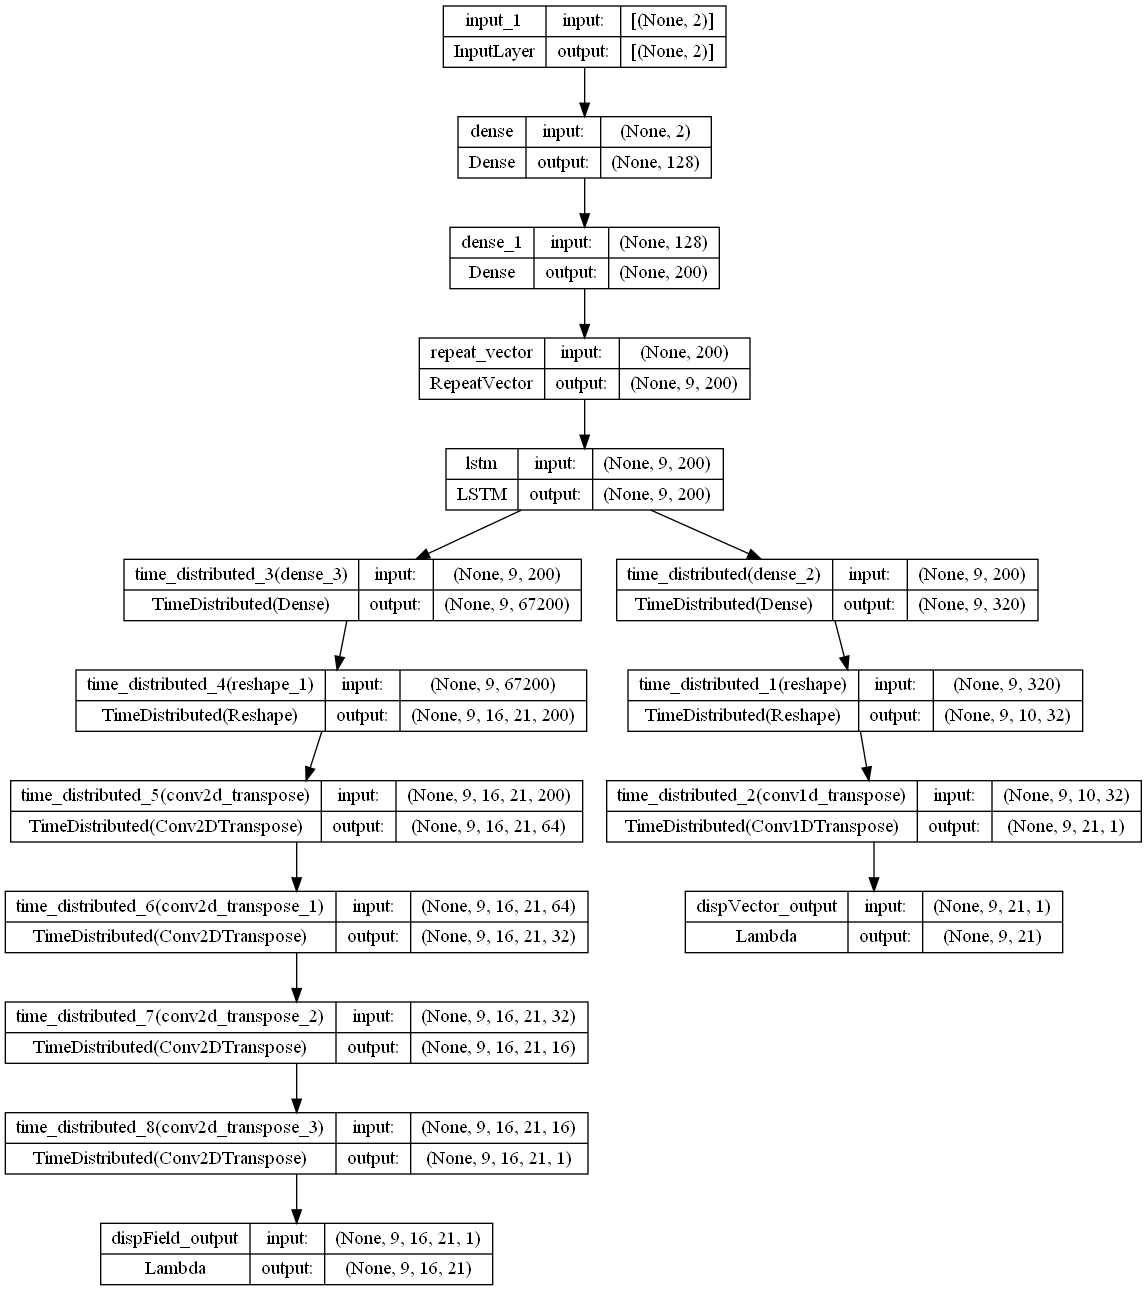

In [3]:
#start to build the NN (I personally prefer the functional API rather than the sequential API)
# Define the input and output features
input_dim = 2
latent_dim = 200
output_timesteps = 9

dispV_dim = 21 #field one-vector dimension
dispfield_dim1 = 16 #field two-dimension1
dispfield_dim2 = 21 #field two-dimension2

# Build the dual output model
model = build_dual_output_model(input_dim, latent_dim, output_timesteps,
                            dispV_dim, dispfield_dim1, dispfield_dim2)
#model.summary()
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
#model.save('saved_model', save_format='tf')



In [4]:
# Run the model
history = model.fit(X_train, [y_train0, y_train1], 
            batch_size=32, 
            epochs=500,
            shuffle=True,
            verbose=2)

Epoch 1/500
8/8 - 4s - loss: 0.6352 - dispVector_output_loss: 0.3015 - dispField_output_loss: 0.3337 - 4s/epoch - 487ms/step
Epoch 2/500
8/8 - 0s - loss: 0.2979 - dispVector_output_loss: 0.1808 - dispField_output_loss: 0.1171 - 183ms/epoch - 23ms/step
Epoch 3/500
8/8 - 0s - loss: 0.1667 - dispVector_output_loss: 0.0939 - dispField_output_loss: 0.0727 - 183ms/epoch - 23ms/step
Epoch 4/500
8/8 - 0s - loss: 0.1011 - dispVector_output_loss: 0.0584 - dispField_output_loss: 0.0427 - 187ms/epoch - 23ms/step
Epoch 5/500
8/8 - 0s - loss: 0.0740 - dispVector_output_loss: 0.0421 - dispField_output_loss: 0.0319 - 186ms/epoch - 23ms/step
Epoch 6/500
8/8 - 0s - loss: 0.0533 - dispVector_output_loss: 0.0290 - dispField_output_loss: 0.0243 - 195ms/epoch - 24ms/step
Epoch 7/500
8/8 - 0s - loss: 0.0412 - dispVector_output_loss: 0.0207 - dispField_output_loss: 0.0205 - 179ms/epoch - 22ms/step
Epoch 8/500
8/8 - 0s - loss: 0.0322 - dispVector_output_loss: 0.0153 - dispField_output_loss: 0.0169 - 195ms/epoc

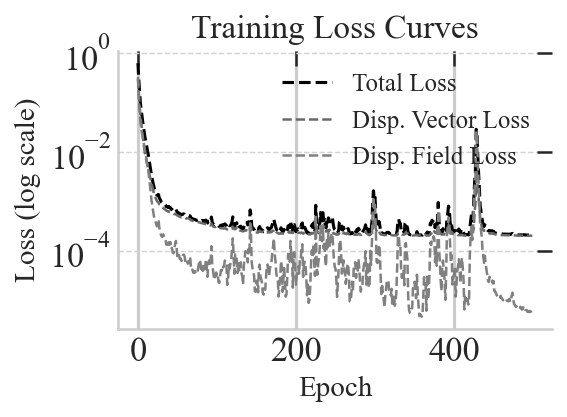

In [5]:
# plot the loss
Plotter.plot_loss(history)


In [6]:
# Predict the training data
y_train_pred0, y_train_pred1 = model.predict(X_train)
shape0_train = y_train_pred0.shape
shape1_train = y_train_pred1.shape
y_train_pred0 = y_scaler0.inverse_transform(y_train_pred0.reshape(y_train_pred0.shape[0],-1))
y_train_pred1 = y_scaler1.inverse_transform(y_train_pred1.reshape(y_train_pred1.shape[0],-1))


#get the true values of the training set and the test set
y_train0 = y_scaler0.inverse_transform(y_train0.reshape(y_train0.shape[0],-1))
y_train1 = y_scaler1.inverse_transform(y_train1.reshape(y_train1.shape[0],-1))

# predict the test data
y_test_pred0, y_test_pred1 = model.predict(X_test)
shape0_test = y_test_pred0.shape
shape1_test = y_test_pred1.shape
y_test_pred0 = y_scaler0.inverse_transform(y_test_pred0.reshape(y_test_pred0.shape[0],-1))
y_test_pred1 = y_scaler1.inverse_transform(y_test_pred1.reshape(y_test_pred1.shape[0],-1))

1/1 [==============================] - 0s 52ms/step


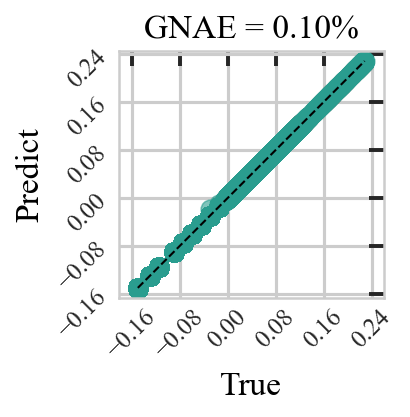

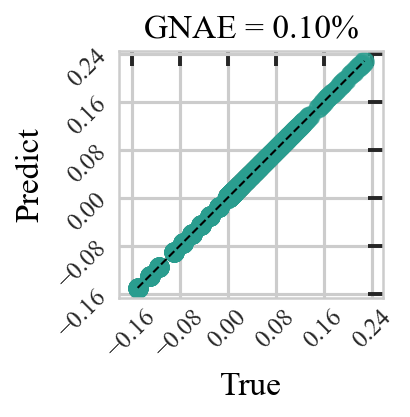

interactive(children=(IntSlider(value=6, description='sample_idx', max=12), Output()), _dom_classes=('widget-i…

In [7]:
# Plotter0 to plot the displacement vector 
# create the Plotter object
plotter0 = Plotter(y_train0, y_train_pred0, y_test0.reshape(y_test0.shape[0],-1), y_test_pred0)


# Plot the scatter plot for training data
plotter0.scatterTraindata()
# Plot the scatter plot for test data
plotter0.scatterTestdata()

# Plot specific samples from the testing data
sample_index = 0  # Change this index to plot different samples
plotter0.disp_Vector(y_test0,shape0_test,y_test_pred0)


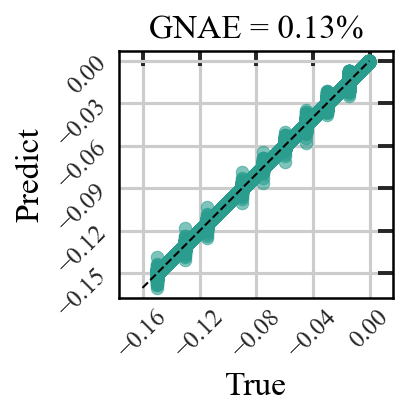

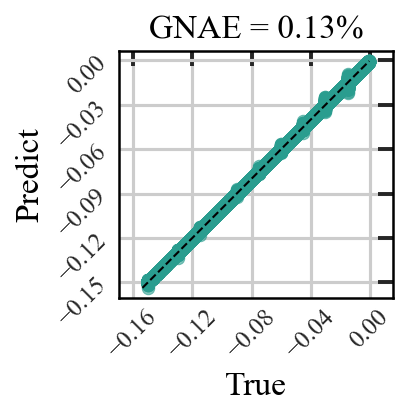

interactive(children=(IntSlider(value=6, description='sample_idx', max=12), IntSlider(value=0, description='ti…

In [8]:
# Plotter1 to plot the displacement field 
# create the Plotter object
plotter1 = Plotter(y_train1, y_train_pred1, y_test1.reshape(y_test1.shape[0],-1), y_test_pred1.reshape(y_test1.shape[0],-1))

# Plot the scatter plot for training data
plotter1.scatterTraindata()
# Plot the scatter plot for test data
plotter1.scatterTestdata()

# reshape the data for heatmap plotting
y_test1 = y_test1.reshape(shape1_test)
y_test_pred1 = y_test_pred1.reshape(shape1_test)

# Plot samples from the testing data
plotter1.disp_Field(y_test1,y_test_pred1)

# save a specific sample FIF from the testing data
sample_idx = 0  # Change this index to get different samples
plotter1.disp_Field_GIF(y_test1,y_test_pred1,sample_idx)